Este script genera graficos de frecuencia instantanea de la DOE vs. tiempo durante el estimulo. Superpone cada estimulacion y las separa en sub-plots por hora consecutiva de estimulacion. Tiene la opcion de separar entre el trial de la mañana y la tarde.

Toma los archivos .pkl obtenidos de 'EOD_analysis.py' y los .csv registrados con bonsai con los timestamps de los on y off del objeto. Puede ser adaptado para graficar raster-plot, graficar todas las horas de estimulacion en uno y cambiar los rangos de tiempo de interes para plotear. 

In [140]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.stats import zscore

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = '/Volumes/Expansion/Datos G. omarorum/Fish3/Objeto/Trial 1 y 2/raw' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_vid = sorted(glob.glob('*.h5'))
files_EOD = sorted(glob.glob('*.bin'))
#definimos parametros
sf = 10000


In [141]:
#cargamos el archivo de FB-DOE
with open('fish3_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in FB_doe['FB-DOE'].keys()]

In [142]:
#inicializamos las listas
EOD_zscore = {}
EOD_freq = FB_doe['FB-DOE']
EOD_t = FB_doe['Peak-time']
hist_bins = []
bin_t = []

In [143]:
for i,key in enumerate(EOD_freq.keys(), start=1):
    freq = EOD_freq[key]
    peak = EOD_t[key]
    EOD_zscore[key] = zscore(freq)
    
    ##creamos el vector t en totalseconds del dia
    midnight = files_start[i-1].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[i-1]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[i-1],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+20*60, num=len(EOD))
    del EOD

    bin_edges = np.arange(time_EOD[0], time_EOD[-1], 30)
    for j, e in enumerate(bin_edges, start=1):
        if j < len(bin_edges):
            range_bin = [e, bin_edges[j]]
            zscore_bin = [x for x,y in zip(EOD_zscore[key], time_EOD[peak]) if y > range_bin[0] and y < range_bin[1]]
            events_bin = [x for x in zscore_bin if x > 1.2]
            bin_t.append(range_bin[0])
            hist_bins.append(len(events_bin))
    

In [144]:
histograma = pd.DataFrame(zip(bin_t, hist_bins), columns=['Tiempo', 'Eventos'])
histograma['objeto'] = ['Objeto' if 61200 < x < 75600 else 'Basal' for x in bin_t]
histograma['objeto'] = ['Objeto' if 18000 < x < 32400  else y for x,y in zip(histograma['Tiempo'], histograma['objeto'])]
histograma['color'] = ['violet' if x == 'Objeto' else 'k' for x in histograma['objeto']]
histograma.head()

,Tiempo,Eventos,objeto,color
0,61371.0,2,Objeto,violet
1,61401.0,26,Objeto,violet
2,61431.0,179,Objeto,violet
3,61461.0,364,Objeto,violet
4,61491.0,924,Objeto,violet


In [145]:
condicion = histograma.groupby('objeto')
print(condicion['Eventos'].std())

objeto
Basal     267.987627
Objeto    340.894846
Name: Eventos, dtype: float64


In [146]:
xtickslab = ['17', '21', '1 am', '5 am', '9 am']
xticks = [0, 480,960,1440,1920]


/var/folders/dk/0fvz37fn27l9149spycxsyf80000gp/T/ipykernel_79178/2386548385.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(xtickslab)


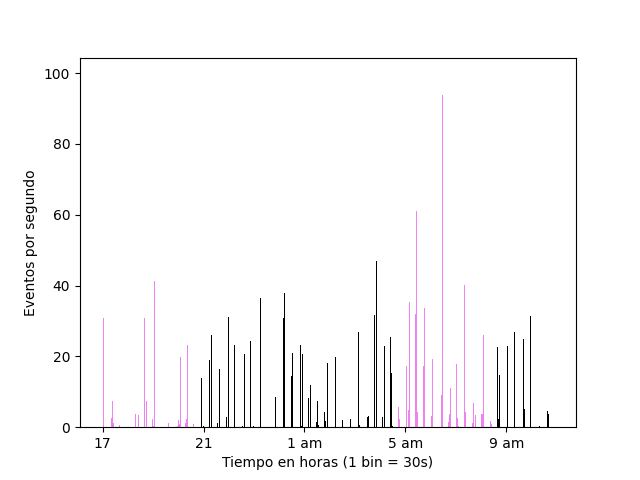

In [147]:
%matplotlib widget
ax1, fig = plt.subplots()
plt.bar(
    x=range(len(histograma)),
    height=[x/30 for x in histograma['Eventos']],
    color=histograma['color']
)
fig.set_ylabel('Eventos por segundo')
fig.set_xlabel('Tiempo en horas (1 bin = 30s)')
fig.set_xticklabels(xtickslab)
fig.set_xticks(xticks)
plt.show()     

In [148]:
len(histograma)

2145